<a href="https://colab.research.google.com/github/Veleces/Project/blob/main/Stock_Price_Prediction_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Model 
Herramienta diseñada para pronosticar el comportamiento de un intrumento bursátil (Stock,ETF) para los próximos N días.

Nota: Los resultados de este modelo no son consejo de inversión.

# Instalación de librerías 
Instalamos las librerías necesarias para ejecutar este modelo (10 minutos aproximadamente)

In [37]:
# install.packages("quantmod")
# install.packages("lubridate")
# install.packages("dplyr")
# install.packages("tidyr")
# install.packages("ggplot2")
# install.packages("caret")
# install.packages("lattice")
# install.packages('TTR')
# install.packages("randomForest")
# install.packages("magrittr")
# install.packages("parallel")
# install.packages("doParallel")

In [38]:
# Llamamos a las librerías para poder utilizarlas 

library(quantmod)
library(lubridate)
library(dplyr)
library(tidyr)
library(ggplot2)
library(caret)
library(lattice)
library(TTR)
library(randomForest)
library(magrittr)
library(parallel)
library(doParallel)


In [5]:
# Creamos las variables globales que nos permitirán personalizar nuestro modelo

# Ticker de nuestra acción (nombre con el que cotiza en bolsa)

ticker <- "NVDA" 

# Fecha inicial con la cual empezaremos a recabar nuestros datos, la fecha inicial 
# será "1900-01-01" para no poner la fecha inicial específica

first_date <- as.Date("1900-01-01")

# Fecha hasta la cual recabaremos nuestros datos

today <- as.Date("2023-04-30")

# Rango de días que queremos pronosticar 

prediction_days <- 5

# Porcentaje de datos que vamos a entrenar

Percentage <- 0.85


# Recolección de datos 
Recabaremos nuestros datos del instrumento a pronosticar 

In [6]:
# Recolectamos nuestros datos históricos del ticker 

stock <- getSymbols(ticker, src = "yahoo", from = first_date,
                    to = today, periodicity = "daily", auto.assign = FALSE)

# Utilizamos el na.omit para omitir los NA al recolectar nuestros datos

stock <- na.omit(stock)

# Comprobamos que no tengas ningún valor NA

sum(is.na(stock))


[1] 0

In [7]:
# Mostranos los datos recolectados
head(stock)
tail(stock)

           NVDA.Open NVDA.High NVDA.Low NVDA.Close NVDA.Volume NVDA.Adjusted
1999-01-22  0.437500  0.488281 0.388021   0.410156   271468800     0.3763577
1999-01-25  0.442708  0.458333 0.410156   0.453125    51048000     0.4157858
1999-01-26  0.458333  0.467448 0.411458   0.417969    34320000     0.3835269
1999-01-27  0.419271  0.429688 0.395833   0.416667    24436800     0.3823321
1999-01-28  0.416667  0.419271 0.412760   0.415365    22752000     0.3811375
1999-01-29  0.415365  0.416667 0.395833   0.395833    24403200     0.3632150

           NVDA.Open NVDA.High NVDA.Low NVDA.Close NVDA.Volume NVDA.Adjusted
2023-04-21    269.52    271.83   267.22     271.19    34476600        271.19
2023-04-24    270.13    273.66   266.71     270.42    33928200        270.42
2023-04-25    270.78    272.47   262.25     262.41    37852700        262.41
2023-04-26    270.02    273.30   267.05     269.56    40633700        269.56
2023-04-27    273.63    274.95   266.25     272.26    37716100        272.26
2023-04-28    272.25    277.58   270.71     277.49    29168700        277.49

# Visualización de Datos

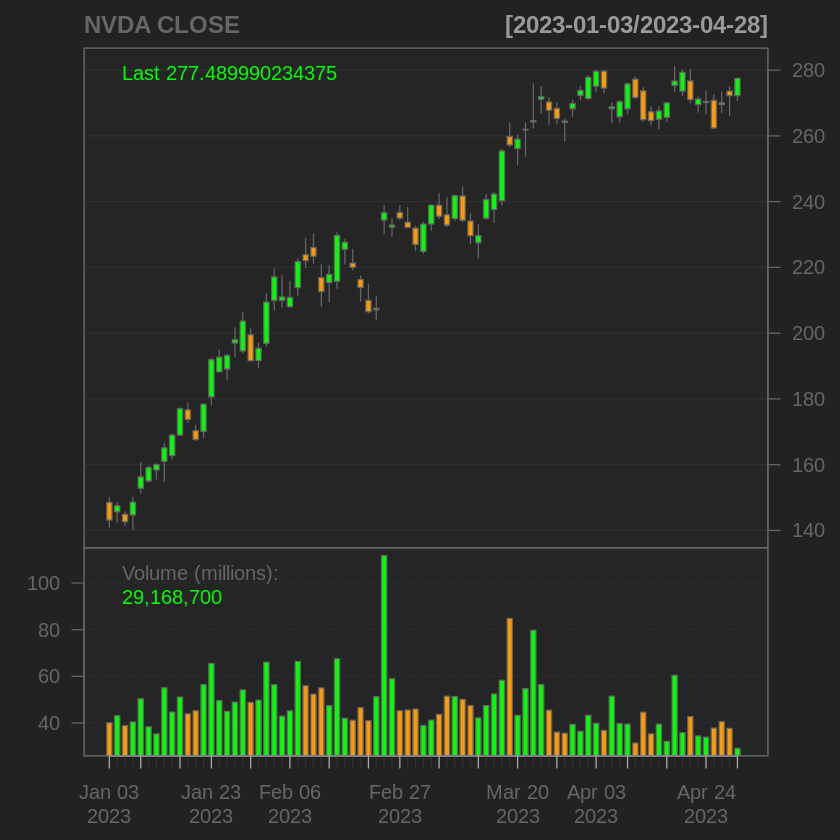

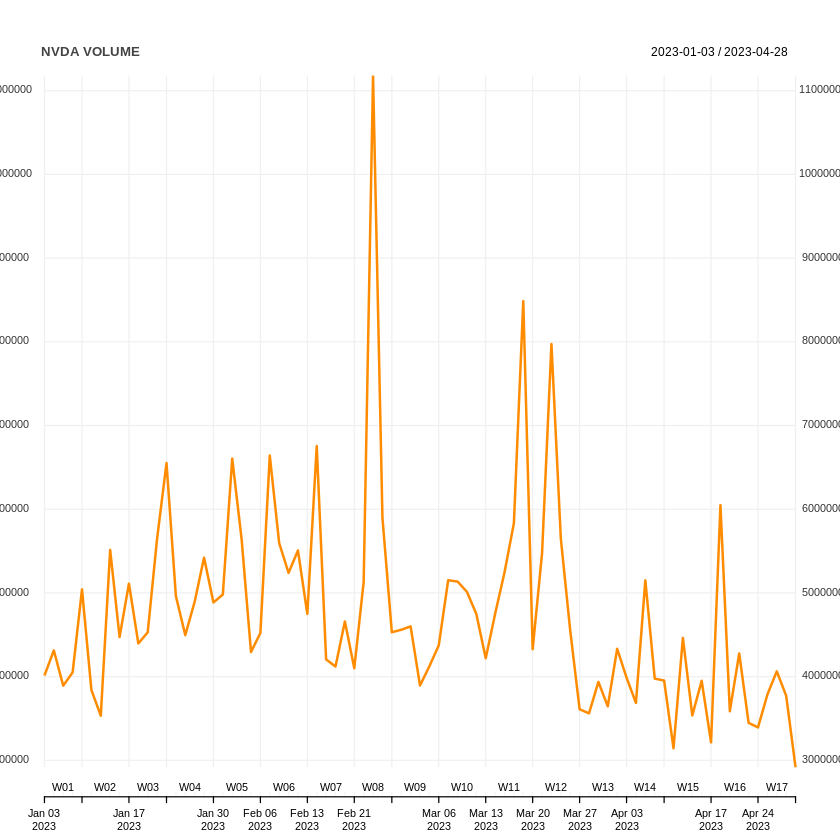

In [8]:
# Gráficamos nuestros datos (Open, High, Low, Volume y Close)

dates <- paste0("2023-01-01::", today)

stock_chart <- chartSeries(stock, 
                           name = paste0(ticker, " CLOSE"), 
                           theme = "black", 
                           subset = dates)

vol_chart <- chart_Series(stock[ , 5],
                          name =paste0(ticker, " VOLUME"),
                          subset = dates)
vol_chart

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


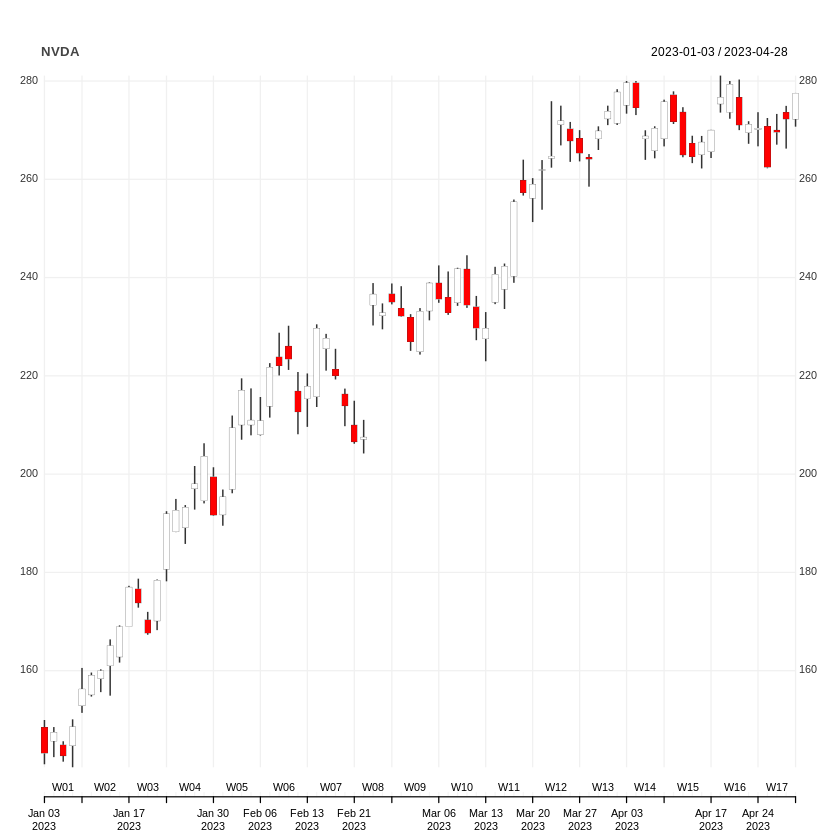

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


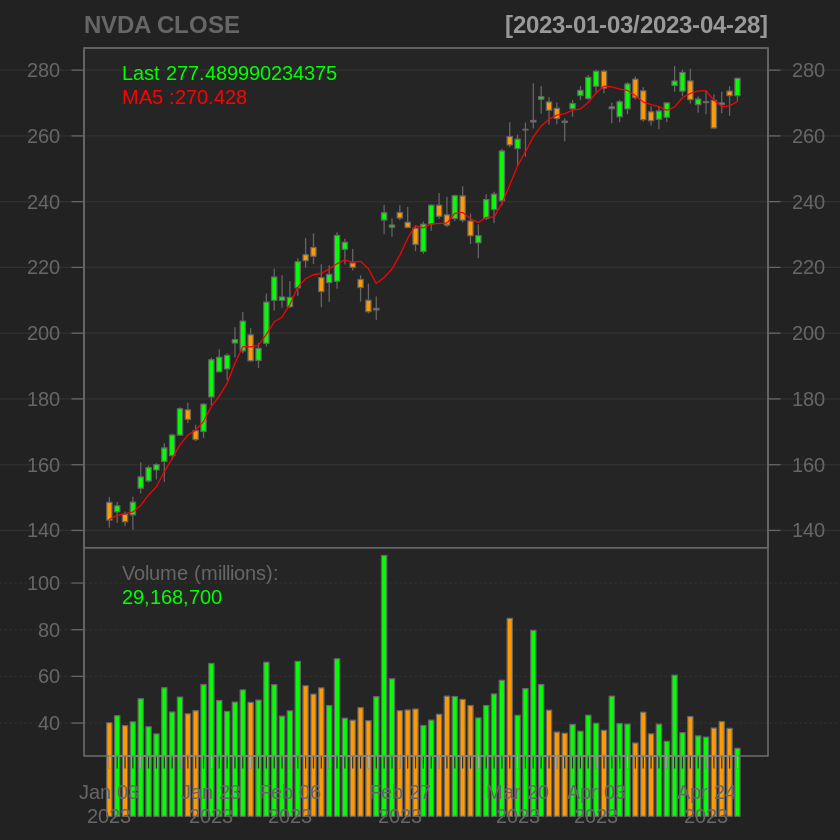

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


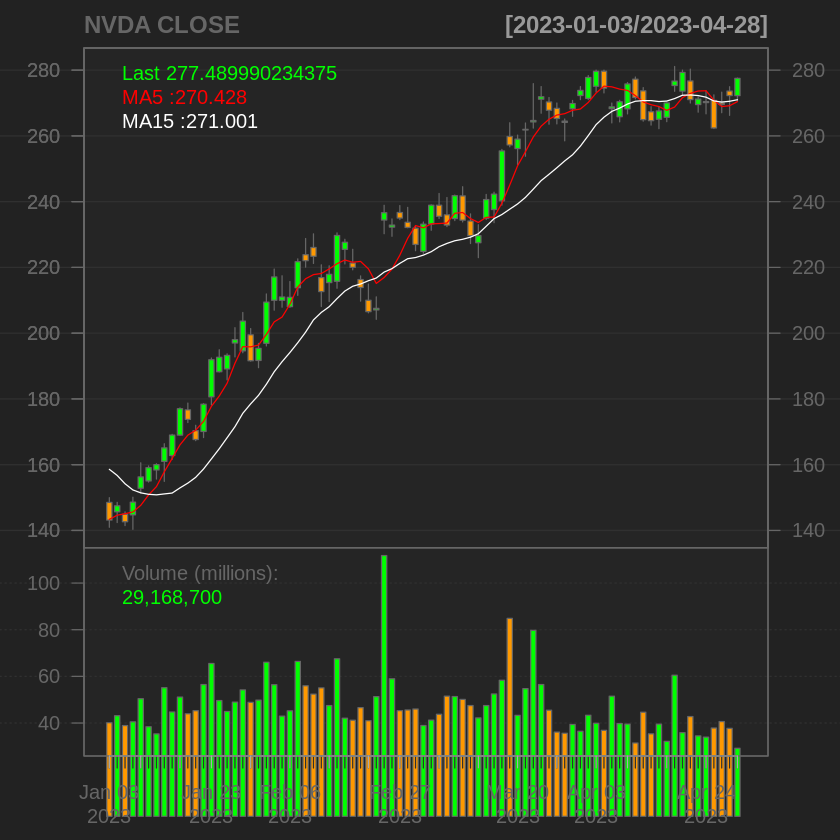

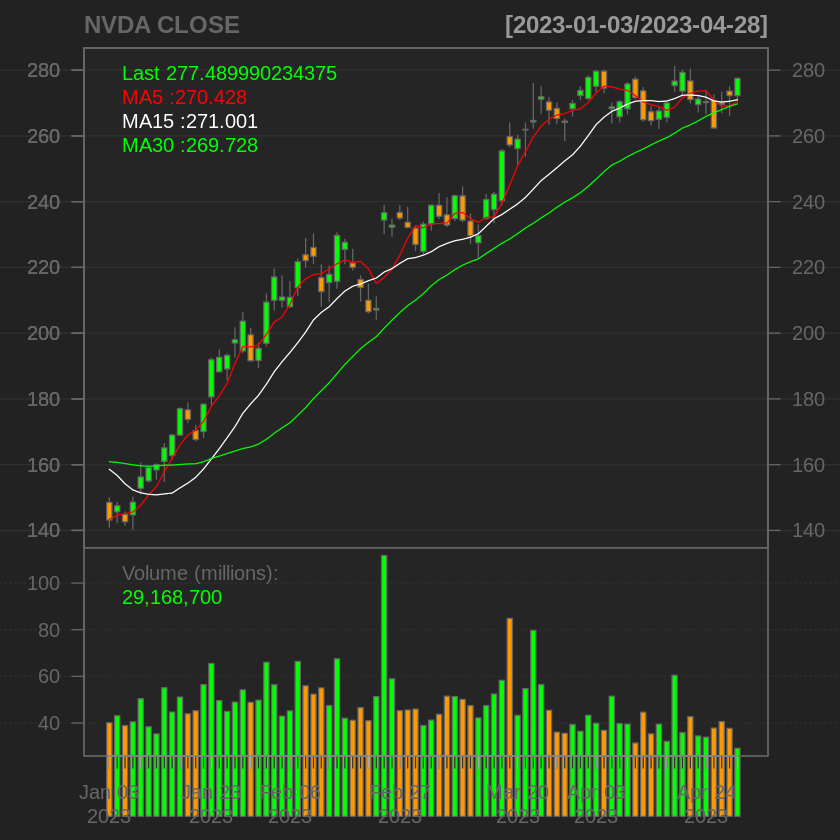

In [9]:
# Gráficamos las medias móviles de 5, 15 y 30 días

# Calculamos las medias móviles

MA5 <- na.omit(SMA(Cl(stock), n = 5))
MA15 <- na.omit(SMA(Cl(stock), n = 15))
MA30 <- na.omit(SMA(Cl(stock), n = 30))

# Creamos nuestros gráficos

chart_Series(stock, name = ticker, TA = NULL, subset = dates)

addTA(MA5, on = 1, col = "red", subset = dates)
addTA(MA15, on = 1, col = "white", subset = dates)
addTA(MA30, on = 1, col = "green", subset = dates)

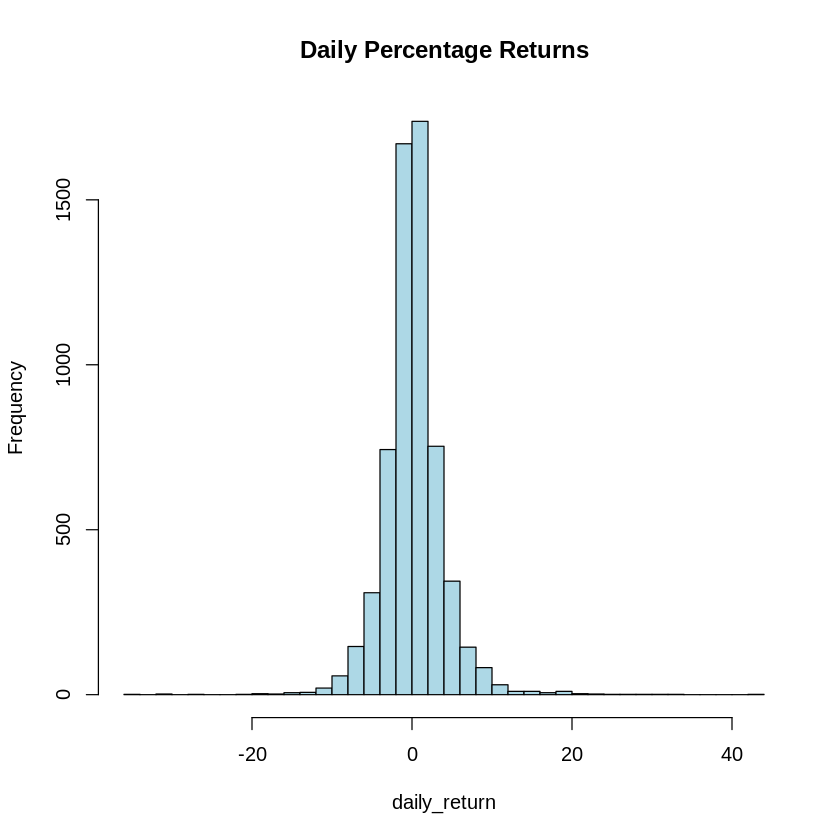

In [10]:
# Gráficamos la distribución de los retornos porcentuales diarios

daily_return <- Delt(stock[ , 6], type = "arithmetic") * 100

hist(daily_return, breaks = 30, col = "lightblue", main = "Daily Percentage Returns")


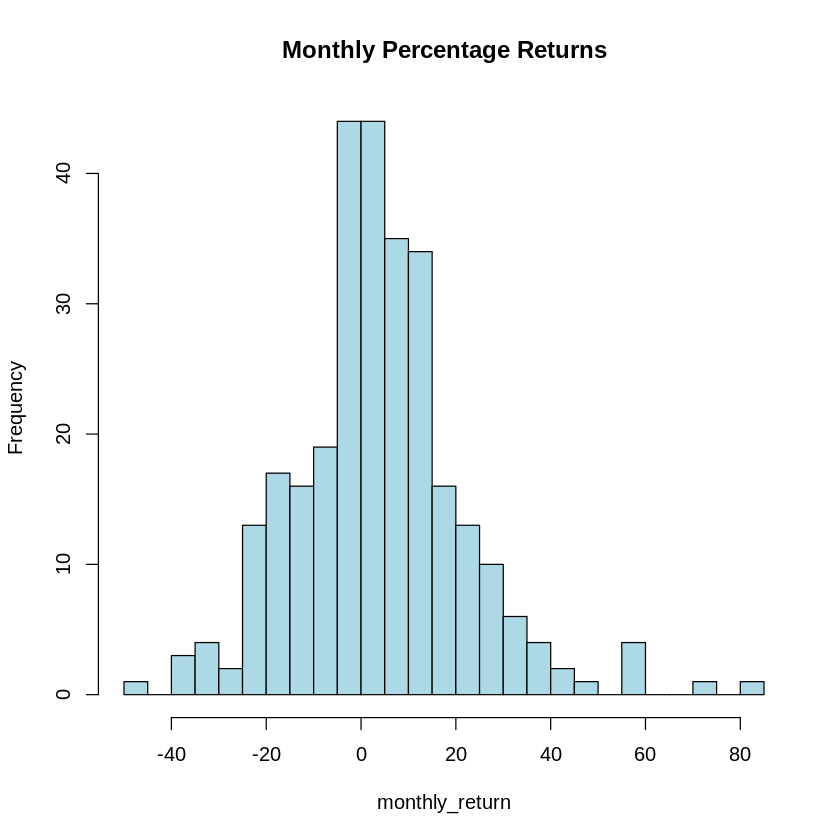

In [11]:
# Gráficamos la distribución de los retornos porcentuales mensuales

monthly_stock <- getSymbols(ticker, src = "yahoo", from = first_date,
                            to = today, periodicity = "monthly", 
                            auto.assign = FALSE)

monthly_return <- Delt(monthly_stock[ , 6], type = "arithmetic") * 100

hist(monthly_return, breaks = 30, col = "lightblue", main = "Monthly Percentage Returns")


# Ingeniería / selección de características más limpieza de datos
Vamos a omitir la columna Close ya que viene siendo la misma que adjusted close.

In [12]:
# Convertimos los datos de stock formato xts a Data Frame de dos columnas
# Utilizamos el na.omit para omitir los na al recolectar nuestros datos

stock_open <- as.data.frame(stock[ , 1])
stock_high <- as.data.frame(stock[ , 2])
stock_low <- as.data.frame(stock[ , 3]) 
stock_volume <- as.data.frame(stock[ , 5])
stock_adj_close <- as.data.frame(stock[ , 6])

# Se muestra el ejemplo de un Data Frame
head(stock_adj_close)

,NVDA.Adjusted
,<dbl>
1999-01-22,0.3763577
1999-01-25,0.4157858
1999-01-26,0.3835269
1999-01-27,0.3823321
1999-01-28,0.3811375
1999-01-29,0.3632150


In [13]:
# Pasamos las fechas que están como fila a columnas 

stock_open$Date <- rownames(stock_open)
stock_high$Date <- rownames(stock_high)
stock_low$Date <- rownames(stock_low)
stock_volume$Date <- rownames(stock_volume)
stock_adj_close$Date <- rownames(stock_adj_close)

# Se muestra un ejemplo
head(stock_adj_close)
tail(stock_adj_close)

,NVDA.Adjusted,Date
,<dbl>,<chr>
1999-01-22,0.3763577,1999-01-22
1999-01-25,0.4157858,1999-01-25
1999-01-26,0.3835269,1999-01-26
1999-01-27,0.3823321,1999-01-27
1999-01-28,0.3811375,1999-01-28
1999-01-29,0.3632150,1999-01-29


,NVDA.Adjusted,Date
,<dbl>,<chr>
2023-04-21,271.19,2023-04-21
2023-04-24,270.42,2023-04-24
2023-04-25,262.41,2023-04-25
2023-04-26,269.56,2023-04-26
2023-04-27,272.26,2023-04-27
2023-04-28,277.49,2023-04-28


In [14]:
# Eliminamos las filas de fechas

rownames(stock_open) <- NULL
rownames(stock_high) <- NULL
rownames(stock_low) <- NULL
rownames(stock_volume) <- NULL
rownames(stock_adj_close) <- NULL

# Asignamos nombres a nuestras dos columnas

names(stock_open) <- c("Open", "Date")
names(stock_high) <- c("High", "Date")
names(stock_low) <- c("Low", "Date")
names(stock_volume) <- c("Volume", "Date")
names(stock_adj_close) <- c("Adjusted_close", "Date")

# Las columnas Date se encuentran en formato Character, debemos
# convertilas a Formato Date

stock_open$Date <- as.Date(stock_open$Date)
stock_high$Date <- as.Date(stock_high$Date)
stock_low$Date <- as.Date(stock_low$Date)
stock_volume$Date <- as.Date(stock_volume$Date)
stock_adj_close$Date <- as.Date(stock_adj_close$Date)

# Visualizamos el resultado

head(stock_adj_close)
tail(stock_adj_close)


,Adjusted_close,Date
,<dbl>,<date>
1,0.3763577,1999-01-22
2,0.4157858,1999-01-25
3,0.3835269,1999-01-26
4,0.3823321,1999-01-27
5,0.3811375,1999-01-28
6,0.3632150,1999-01-29


,Adjusted_close,Date
,<dbl>,<date>
6102,271.19,2023-04-21
6103,270.42,2023-04-24
6104,262.41,2023-04-25
6105,269.56,2023-04-26
6106,272.26,2023-04-27
6107,277.49,2023-04-28


Creamos un rango de fechas, estos días son los que vamos a pronosticar. En este caso queremos pronosticar n días, estos días tendrán valor númerico NA y vamos a omitir los días sábados y domingos en nuestro rango de fechas.

In [15]:
# Variabales globales para el rango de fechas (Contando que el pronóstico
# se hace todos los sábados)

start_date <- today 
end_date <- today + prediction_days

# date_range_open

date_range_open <- seq(start_date, end_date, by = "day")
date_range_open <- subset(date_range_open, 
                          !(weekdays(date_range_open) %in% c("Saturday",
                                                               "Sunday")))
Open <- as.numeric(NA)
date_range_open <- as.data.frame(cbind(Open, date_range_open))

date_range_open$Date <- as.Date(date_range_open$date_range_open)
date_range_open$date_range_open <- NULL 

# date_range_high

date_range_high <- seq(start_date, end_date, by = "day")
date_range_high <- subset(date_range_high, 
                          !(weekdays(date_range_high) %in% c("Saturday",
                                                             "Sunday")))
High <- as.numeric(NA)
date_range_high <- as.data.frame(cbind(High, date_range_high))

date_range_high$Date <- as.Date(date_range_high$date_range_high)
date_range_high$date_range_high <- NULL 

# date_range_low

date_range_low <- seq(start_date, end_date, by = "day")
date_range_low <- subset(date_range_low, 
                          !(weekdays(date_range_low) %in% c("Saturday",
                                                             "Sunday")))
Low <- as.numeric(NA)
date_range_low <- as.data.frame(cbind(Low, date_range_low))

date_range_low$Date <- as.Date(date_range_low$date_range_low)
date_range_low$date_range_low <- NULL 

# date_range_vol

date_range_vol <- seq(start_date, end_date, by = "day")
date_range_vol <- subset(date_range_vol, 
                         !(weekdays(date_range_vol) %in% c("Saturday",
                                                           "Sunday")))
Volume <- as.numeric(NA)
date_range_vol <- as.data.frame(cbind(Volume, date_range_vol))

date_range_vol$Date <- as.Date(date_range_vol$date_range_vol)
date_range_vol$date_range_vol <- NULL 

# date_range_adjcl

date_range_adjcl <- seq(from = start_date, to = end_date, by = "day")
date_range_adjcl <- subset(date_range_adjcl, 
                         !(weekdays(date_range_adjcl) %in% c("Saturday",
                                                           "Sunday")))
Adjusted_close <- as.numeric(NA)
date_range_adjcl <- as.data.frame(cbind(Adjusted_close, date_range_adjcl))

date_range_adjcl$Date <- as.Date(date_range_adjcl$date_range_adjcl)
date_range_adjcl$date_range_adjcl <- NULL 


In [16]:
# Contamos los días totales del rango de fecha de 30 días, excluyendo 
# sábados y domingos y lo almacenamos en la variable days_range

days_range <- as.numeric(length(date_range_adjcl[ , 1]))

cat(days_range, "days")


5 days

In [17]:
# Unimos nuestros rango de fechas al Data Frame que le corresponde, ejemplo:
# Unir date_range_open con stock_open

stock_open <- rbind(stock_open, date_range_open)
stock_high <- rbind(stock_high, date_range_high)
stock_low <- rbind(stock_low, date_range_low)
stock_volume <- rbind(stock_volume, date_range_vol)
stock_adj_close <- rbind(stock_adj_close, date_range_adjcl)

# Visualizamos un resultado de los Data Frames juntos

tail(stock_adj_close, days_range + 1)

,Adjusted_close,Date
,<dbl>,<date>
6107,277.49,2023-04-28
6108,NA,2023-05-01
6109,NA,2023-05-02
6110,NA,2023-05-03
6111,NA,2023-05-04
6112,NA,2023-05-05


# Selección de características

In [18]:
# Duplicanos la columna fecha, para no perderla ya que vamos a dividir
# esta columna en tres: Year, Month y Day. Y posteriormente nos 
# servirá para gráficar nuestros resultados 

stock_open$Dup_Date = stock_open$Date
stock_high$Dup_Date = stock_high$Date
stock_low$Dup_Date = stock_low$Date
stock_volume$Dup_Date = stock_volume$Date
stock_adj_close$Dup_Date = stock_adj_close$Date

stock_open <- stock_open %>% separate(Date, c("Year", "Month", "Day"))
stock_high <- stock_high %>% separate(Date, c("Year", "Month", "Day"))
stock_low <- stock_low %>% separate(Date, c("Year", "Month", "Day"))
stock_volume <- stock_volume %>% separate(Date, c("Year", "Month", "Day"))
stock_adj_close <- stock_adj_close %>% separate(Date, c("Year", "Month", "Day"))

# Resultado 
tail(stock_adj_close, days_range + 1)

,Adjusted_close,Year,Month,Day,Dup_Date
,<dbl>,<chr>,<chr>,<chr>,<date>
6107,277.49,2023,04,28,2023-04-28
6108,NA,2023,05,01,2023-05-01
6109,NA,2023,05,02,2023-05-02
6110,NA,2023,05,03,2023-05-03
6111,NA,2023,05,04,2023-05-04
6112,NA,2023,05,05,2023-05-05


In [19]:
# Convertimos las tres columnas Year, Month y Day en formato númerico

stock_open$Year = as.numeric(stock_open$Year)
stock_high$Year = as.numeric(stock_high$Year)
stock_low$Year = as.numeric(stock_low$Year)
stock_volume$Year = as.numeric(stock_volume$Year)
stock_adj_close$Year = as.numeric(stock_adj_close$Year)

stock_open$Month = as.numeric(stock_open$Month)
stock_high$Month = as.numeric(stock_high$Month)
stock_low$Month = as.numeric(stock_low$Month)
stock_volume$Month = as.numeric(stock_volume$Month)
stock_adj_close$Month = as.numeric(stock_adj_close$Month)

stock_open$Day = as.numeric(stock_open$Day)
stock_high$Day = as.numeric(stock_high$Day)
stock_low$Day = as.numeric(stock_low$Day)
stock_volume$Day = as.numeric(stock_volume$Day)
stock_adj_close$Day = as.numeric(stock_adj_close$Day)


In [20]:
head(stock_adj_close)
tail(stock_adj_close, days_range + 1)

,Adjusted_close,Year,Month,Day,Dup_Date
,<dbl>,<dbl>,<dbl>,<dbl>,<date>
1,0.3763577,1999,1,22,1999-01-22
2,0.4157858,1999,1,25,1999-01-25
3,0.3835269,1999,1,26,1999-01-26
4,0.3823321,1999,1,27,1999-01-27
5,0.3811375,1999,1,28,1999-01-28
6,0.3632150,1999,1,29,1999-01-29


,Adjusted_close,Year,Month,Day,Dup_Date
,<dbl>,<dbl>,<dbl>,<dbl>,<date>
6107,277.49,2023,4,28,2023-04-28
6108,NA,2023,5,1,2023-05-01
6109,NA,2023,5,2,2023-05-02
6110,NA,2023,5,3,2023-05-03
6111,NA,2023,5,4,2023-05-04
6112,NA,2023,5,5,2023-05-05


# Modelo de Machine Learning Random Forest
Justificación

Elegí el modelo de Random Forest porque no es necesario escalar los datos como en un modelo de Deep Learning, además es un método de ensamble que combina múltiples árboles de decisión para reducir la varianza, esto me puede ser útil en el caso de la predicción del precio de una acción, donde los datos pueden ser ruidosos, además con este modelo me puede servir para saber que características son más importantes para predecir el precio de la acción, que en cambio con un modelo de Red Neuronal no se sabe con exaxtitud como es que este toma sus decisiones y principalmente porque el tiempo de entrenamiento es más corto, por si lo quiero adaptar junto a un modelo de Trading Algortimico.

In [21]:
# Actualizamos nuestra variable today para crear nuestro datos de entrenamiento
# y los de validación

today <- as.Date(date_range_adjcl[2][,1][1])
today


[1] "2023-05-01"

In [22]:
# Creamos los datos de entrenamiento y validación por cada Data Frame
# Esto con la finalidad de relizar predicciones individuales de nuestras 
# caracterpisticas y después unirlas para predecir Adjusted Close

# Open

set.seed(1900)

open_train_data = createDataPartition(na.omit(subset(
  stock_open, stock_open$Dup_Date < today))$Open,
  p = Percentage, list = FALSE)

open_test = rbind(stock_open[-open_train_data, ], 
                  subset(stock_open, stock_open$Dup_Date >= today))

# High

set.seed(1900)

high_train_data = createDataPartition(na.omit(subset(
  stock_high, stock_high$Dup_Date < today))$High,
  p = Percentage, list = FALSE)

high_test = rbind(stock_high[-high_train_data, ], 
                  subset(stock_high, stock_high$Dup_Date >= today))

# Low

set.seed(1900)

low_train_data = createDataPartition(na.omit(subset(
  stock_low, stock_low$Dup_Date < today))$Low,
  p = Percentage, list = FALSE)

low_test = rbind(stock_low[-low_train_data, ], 
                  subset(stock_low, stock_low$Dup_Date >= today))

# Volume

set.seed(1900)

vol_train_data = createDataPartition(na.omit(subset(
  stock_volume, stock_volume$Dup_Date < today))$Volume,
  p = Percentage, list = FALSE)

vol_test = rbind(stock_volume[-vol_train_data, ], 
                  subset(stock_volume, stock_volume$Dup_Date >= today))


In [23]:
# Eliminamos las N filas adicionales equivalentes a days_range que nos agregó test

open_test <- open_test[1 : (nrow(open_test) - days_range), ]
high_test <- high_test[1 : (nrow(high_test) - days_range), ]
low_test <- low_test[1 : (nrow(low_test) - days_range), ] 
vol_test <- vol_test[1 : (nrow(vol_test) - days_range), ]


In [24]:
# Datos informativos sobre nuestros Data Frames

t <- length(vol_train_data[,1])
ts <- length(vol_test[,1])
sum <- sum(t + ts)
result <- sum - days_range

cat("Filas en nuestro Df ticker:", length(stock[,6]),
"\nFilas de days_range (días a predecir):", days_range,
"\nFilas ticker + filas de predicción:", length(stock[,6])  + days_range,
"\nFilas del train:", t,
"\nFilas del test:", ts,
"\nSuma train y test filas:", sum,
"\nTiker Df con filas de predicción - filas days_range:", result)

Filas en nuestro Df ticker: 6107 
Filas de days_range (días a predecir): 5 
Filas ticker + filas de predicción: 6112 
Filas del train: 5192 
Filas del test: 920 
Suma train y test filas: 6112 
Tiker Df con filas de predicción - filas days_range: 6107

In [25]:
tail(vol_test, days_range + 1)

,Volume,Year,Month,Day,Dup_Date
,<dbl>,<dbl>,<dbl>,<dbl>,<date>
6107,29168700,2023,4,28,2023-04-28
6108,NA,2023,5,1,2023-05-01
6109,NA,2023,5,2,2023-05-02
6110,NA,2023,5,3,2023-05-03
6111,NA,2023,5,4,2023-05-04
6112,NA,2023,5,5,2023-05-05


In [26]:
# Creamos nuestro Modelo de Random Forest para cada característica
# Los pronósticos los usaremos para predecir Adjusted Close

# Open

open_rf_model = randomForest(Open ~ Year + Month + Day,
                             data = stock_open[open_train_data, ],
                             type = "regression",
                             ntree = 4478,
                             mtry = 3,
                             nodesize = 5,
                             maxnodes = 600)

open_rf_pred = predict(open_rf_model, open_test)

open_rf_datos = cbind(open_rf_pred, open_test)

open_rf_rmse = RMSE(open_rf_datos$Open, open_rf_datos$open_rf_pred,
                         na.rm = TRUE)

# High

high_rf_model = randomForest(High ~ Year + Month + Day,
                             data = stock_high[high_train_data, ],
                             type = "regression",
                             ntree = 4478,
                             mtry = 3,
                             maxnodes = 600)

high_rf_pred = predict(high_rf_model, high_test)

high_rf_datos = cbind(high_rf_pred, high_test)

high_rf_rmse = RMSE(high_rf_datos$High, high_rf_datos$high_rf_pred,
                         na.rm = TRUE)

# Low

low_rf_model = randomForest(Low ~ Year + Month + Day,
                             data = stock_low[low_train_data, ],
                             type = "regression",
                             ntree = 4478,
                             mtry = 3,
                             maxnodes = 600)

low_rf_pred = predict(low_rf_model, low_test)

low_rf_datos = cbind(low_rf_pred, low_test)

low_rf_rmse = RMSE(low_rf_datos$Low, low_rf_datos$low_rf_pred,
                        na.rm = TRUE)

# Volume

vol_rf_model = randomForest(Volume ~ Year + Month + Day,
                            data = stock_volume[vol_train_data, ],
                            type = "regression",
                            ntree = 78,
                            mtry = 3,
                            maxnodes = 600)

vol_rf_pred = predict(vol_rf_model, vol_test)

vol_rf_datos = cbind(vol_rf_pred, vol_test)

vol_rf_rmse = RMSE(vol_rf_datos$Volume, vol_rf_datos$vol_rf_pred,
                        na.rm = TRUE)


In [27]:
tail(open_rf_datos, days_range + 1)

,open_rf_pred,Open,Year,Month,Day,Dup_Date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
6098,273.2942,265.65,2023,4,17,2023-04-17
6108,270.4243,NA,2023,5,1,2023-05-01
6109,270.5365,NA,2023,5,2,2023-05-02
6110,271.1753,NA,2023,5,3,2023-05-03
6111,271.8676,NA,2023,5,4,2023-05-04
6112,267.4311,NA,2023,5,5,2023-05-05


In [28]:
# Se muestra el RMSE de cada predicción 

cat("Open Predict RMSE:", open_rf_rmse, "\nHigh Predict RMSE:", high_rf_rmse,
"\nLow Predict RMSE:", low_rf_rmse, "\nVolume Predict RMSE:", vol_rf_rmse)


Open Predict RMSE: 2.956257 
High Predict RMSE: 2.651719 
Low Predict RMSE: 2.864443 
Volume Predict RMSE: 37413586

In [29]:
# Se muestra los resultados de los modelos anteriores

open_rf_model
high_rf_model
low_rf_model
vol_rf_model


Call:
 randomForest(formula = Open ~ Year + Month + Day, data = stock_open[open_train_data,      ], type = "regression", ntree = 4478, mtry = 3, nodesize = 5,      maxnodes = 600) 
               Type of random forest: regression
                     Number of trees: 4478
No. of variables tried at each split: 3

          Mean of squared residuals: 8.370069
                    % Var explained: 99.77


Call:
 randomForest(formula = High ~ Year + Month + Day, data = stock_high[high_train_data,      ], type = "regression", ntree = 4478, mtry = 3, maxnodes = 600) 
               Type of random forest: regression
                     Number of trees: 4478
No. of variables tried at each split: 3

          Mean of squared residuals: 7.681848
                    % Var explained: 99.8


Call:
 randomForest(formula = Low ~ Year + Month + Day, data = stock_low[low_train_data,      ], type = "regression", ntree = 4478, mtry = 3, maxnodes = 600) 
               Type of random forest: regression
                     Number of trees: 4478
No. of variables tried at each split: 3

          Mean of squared residuals: 7.469942
                    % Var explained: 99.79


Call:
 randomForest(formula = Volume ~ Year + Month + Day, data = stock_volume[vol_train_data,      ], type = "regression", ntree = 78, mtry = 3, maxnodes = 600) 
               Type of random forest: regression
                     Number of trees: 78
No. of variables tried at each split: 3

          Mean of squared residuals: 1.023294e+15
                    % Var explained: 44.75

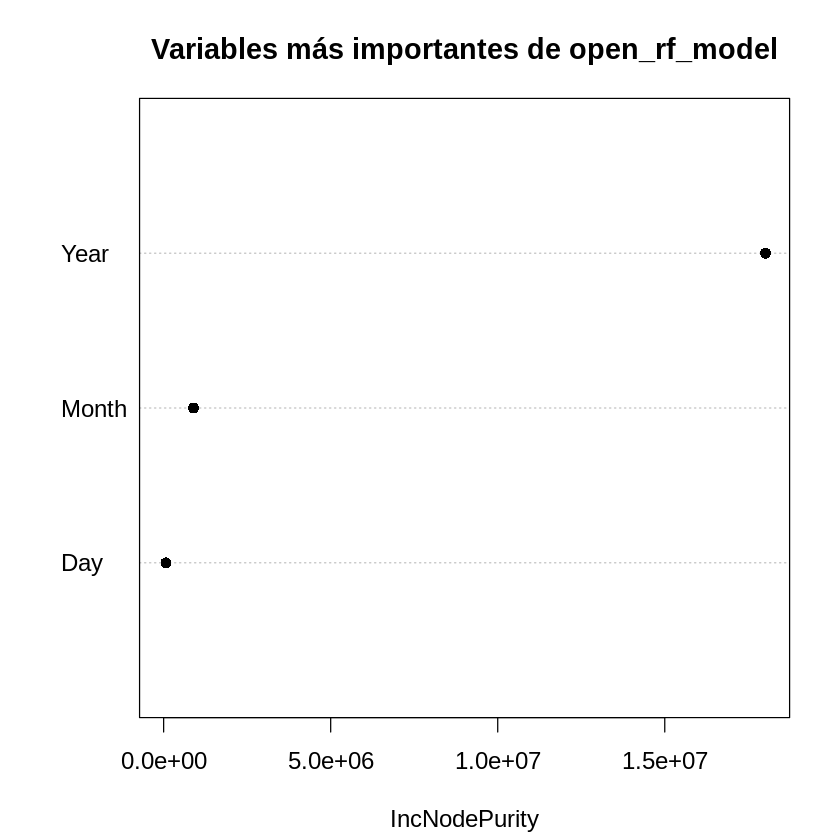

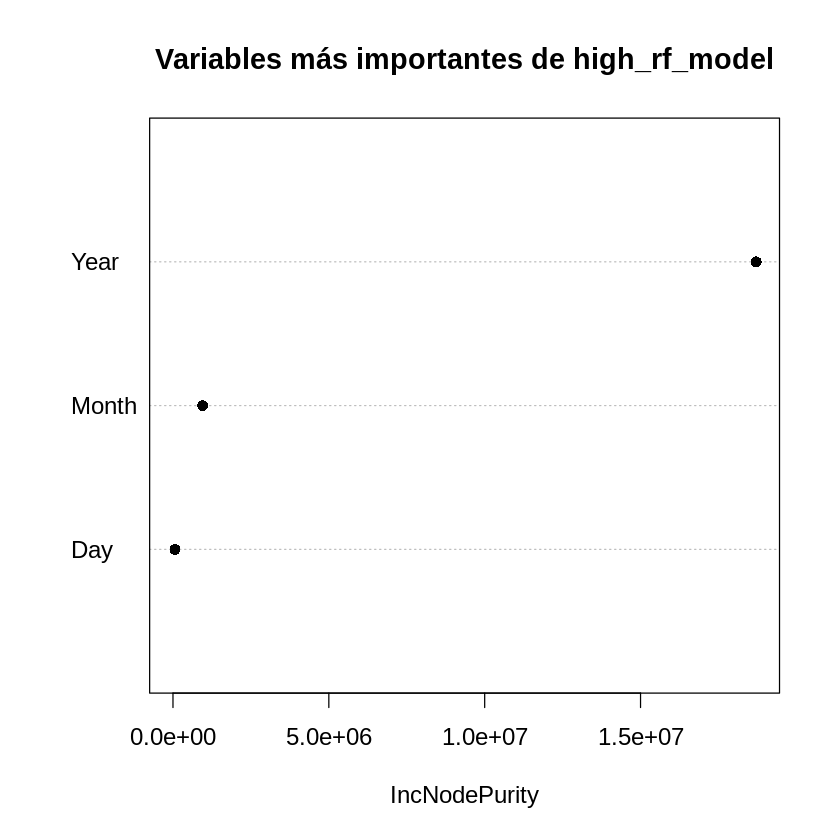

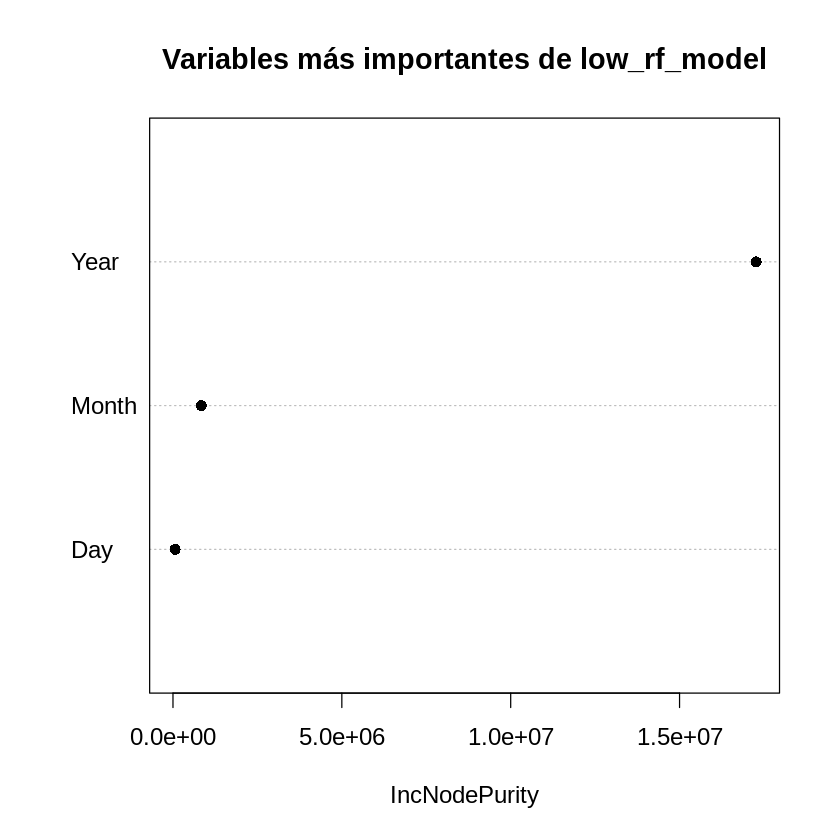

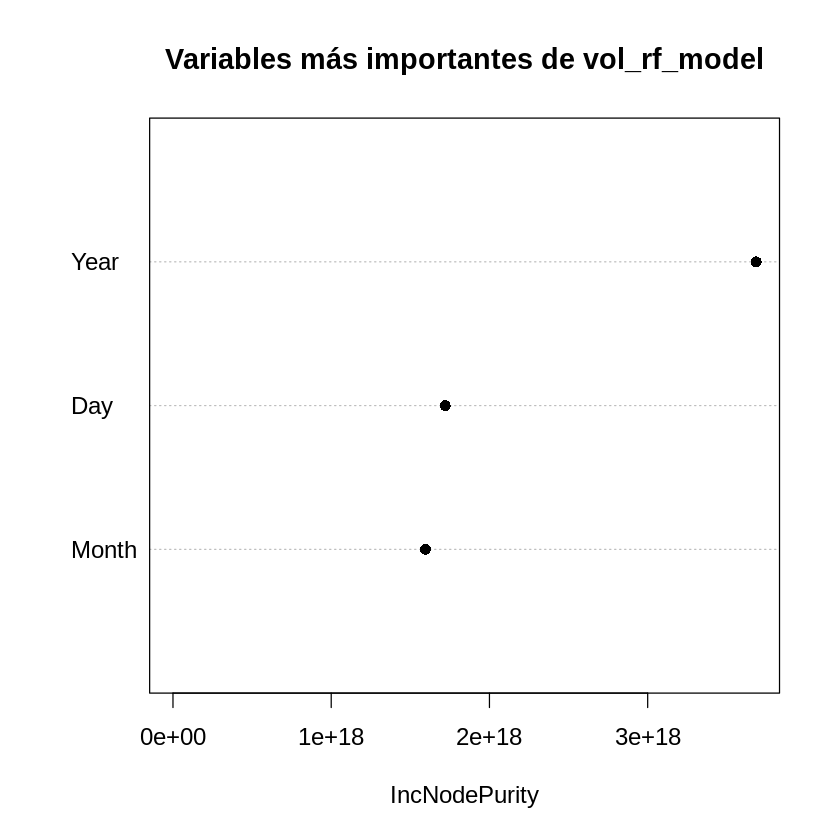

In [30]:
# Visualizamos las variables más importantes de nuestro nuevo modelo

varImpPlot(open_rf_model, main = "Variables más importantes de open_rf_model",
col = "black", pch = 16, cex = 1.2, las = 2)

varImpPlot(high_rf_model, main = "Variables más importantes de high_rf_model",
col = "black", pch = 16, cex = 1.2, las = 2)

varImpPlot(low_rf_model, main = "Variables más importantes de low_rf_model",
col = "black", pch = 16, cex = 1.2, las = 2)

varImpPlot(vol_rf_model, main = "Variables más importantes de vol_rf_model",
col = "black", pch = 16, cex = 1.2, las = 2)


Podemos ver que la variable "Year" tiene gran impacto en el pronóstico de nuestros modelos

In [31]:
# Unimos los valores pronósticados en el Data Frame stock_x

stock_open$Open[(nrow(stock_open) - (days_range - 1)) : nrow(stock_open)] <-
  open_rf_datos$open_rf_pred[(nrow(open_rf_datos) - (days_range - 1)) : 
  nrow(open_rf_datos)]

stock_high$High[(nrow(stock_high) - (days_range - 1)) : nrow(stock_high)] <-
  high_rf_datos$high_rf_pred[(nrow(high_rf_datos) - (days_range - 1)) : 
  nrow(high_rf_datos)]

stock_low$Low[(nrow(stock_low) - (days_range - 1)) : nrow(stock_low)] <-
  low_rf_datos$low_rf_pred[(nrow(low_rf_datos) - (days_range - 1)) : 
  nrow(low_rf_datos)]

stock_volume$Volume[(nrow(stock_volume) - (days_range - 1)) : nrow(stock_volume)] <-
  vol_rf_datos$vol_rf_pred[(nrow(vol_rf_datos) - (days_range - 1)) : 
  nrow(vol_rf_datos)]

# Agregamos las columnas Open, High, Low y Volume a nuestro Data Frame
# Adjusted Close para realizar su pronóstico 

stock_adj_close$Open <- stock_open$Open
stock_adj_close$High <- stock_high$High
stock_adj_close$Low <- stock_low$Low
stock_adj_close$Volume <- stock_volume$Volume

# Visualizamos el nuestro Data Frame stock_adj_close

tail(stock_adj_close, days_range + 1)


,Adjusted_close,Year,Month,Day,Dup_Date,Open,High,Low,Volume
,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
6107,277.49,2023,4,28,2023-04-28,272.2500,277.5800,270.7100,29168700
6108,NA,2023,5,1,2023-05-01,270.4243,272.5679,269.9626,48820815
6109,NA,2023,5,2,2023-05-02,270.5365,272.8729,270.0058,47801590
6110,NA,2023,5,3,2023-05-03,271.1753,273.3476,270.3337,47218614
6111,NA,2023,5,4,2023-05-04,271.8676,273.7717,270.6428,48691668
6112,NA,2023,5,5,2023-05-05,267.4311,269.3057,266.2181,50101299


Creamos nuestro Training y Test Data para el Data Frame stock_adj_close

In [32]:
# Training y Test data para predecir Adjusted Close

set.seed(1900)

adjcl_train_data = createDataPartition(na.omit(subset(
  stock_adj_close, stock_adj_close$Dup_Date < today))$Adjusted_close,
  p = Percentage, list = FALSE)

adjcl_test = rbind(stock_adj_close[-adjcl_train_data, ], 
                   subset(stock_adj_close, stock_adj_close$Dup_Date >= 
                   today))
                   

In [33]:
# Eliminamos las N filas adicionales equivalentes a days_range que nos agregó test

adjcl_test <- adjcl_test[1 : (nrow(adjcl_test) - days_range), ]

In [34]:
# Información sobre nuestros datos

t <- length(adjcl_train_data[,1])
ts <- length(adjcl_test[,1])
sum <- sum(t + ts)
result <- sum - days_range


cat("Filas en nuestro Df ticker:", length(stock[,6]),
"\nFilas de days_range (días a predecir):", days_range,
"\nFilas ticker + filas de predicción:", length(stock[,6])  + days_range,
"\nFilas del train:", t,
"\nFilas del test:", ts,
"\nSuma train y test filas:", sum,
"\nTiker Df con filas de predicción - filas days_range:", result)

Filas en nuestro Df ticker: 6107 
Filas de days_range (días a predecir): 5 
Filas ticker + filas de predicción: 6112 
Filas del train: 5192 
Filas del test: 920 
Suma train y test filas: 6112 
Tiker Df con filas de predicción - filas days_range: 6107

In [35]:
# Duplicar la fecha y moverla hasta el final, eliminar la actual

adjcl_test$Date <- adjcl_test$Dup_Date
tail(adjcl_test, days_range + 1)

,Adjusted_close,Year,Month,Day,Dup_Date,Open,High,Low,Volume,Date
,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
6098,270.02,2023,4,17,2023-04-17,265.6500,270.0600,264.3300,32147100,2023-04-17
6108,NA,2023,5,1,2023-05-01,270.4243,272.5679,269.9626,48820815,2023-05-01
6109,NA,2023,5,2,2023-05-02,270.5365,272.8729,270.0058,47801590,2023-05-02
6110,NA,2023,5,3,2023-05-03,271.1753,273.3476,270.3337,47218614,2023-05-03
6111,NA,2023,5,4,2023-05-04,271.8676,273.7717,270.6428,48691668,2023-05-04
6112,NA,2023,5,5,2023-05-05,267.4311,269.3057,266.2181,50101299,2023-05-05


In [36]:
# Eliminar la columna Dup_Date

adjcl_test$Dup_Date <- NULL
tail(adjcl_test, days_range + 1)

,Adjusted_close,Year,Month,Day,Open,High,Low,Volume,Date
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
6098,270.02,2023,4,17,265.6500,270.0600,264.3300,32147100,2023-04-17
6108,NA,2023,5,1,270.4243,272.5679,269.9626,48820815,2023-05-01
6109,NA,2023,5,2,270.5365,272.8729,270.0058,47801590,2023-05-02
6110,NA,2023,5,3,271.1753,273.3476,270.3337,47218614,2023-05-03
6111,NA,2023,5,4,271.8676,273.7717,270.6428,48691668,2023-05-04
6112,NA,2023,5,5,267.4311,269.3057,266.2181,50101299,2023-05-05


### Modelo de Random Forest para el Data Frame stock_adj_close


In [606]:
# Modelo optimizado para elegir el mtry

library(caret)
library(parallel)
library(doParallel)
cluster <- makeCluster(detectCores() - 1) 
registerDoParallel(cluster) # procesamiento paralelo

# Método de validación cruzada (10-fold)
fitControl <- trainControl(method = "cv", 
                           number = 10, 
                           search = "grid",
                           allowParallel = TRUE)

# Hiperparámetro a optimizar: número de predictores aleatorios en cada ramificación.
grid_mtry <- expand.grid(mtry = c(2:7))

set.seed(356)
modelo_rf <- train(Adjusted_close ~ Year + Month + Day + Open + High + Low + Volume, 
data = stock_adj_close[adjcl_train_data, ], 
method = "rf",
metric = "RMSE",
ntree = 500,
tuneGrid = grid_mtry, 
trControl = fitControl)

modelo_rf


Random Forest 

5192 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4673, 4672, 4672, 4673, 4674, 4672, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE      
  2     1.293691  0.9995405  0.4354244
  3     1.234484  0.9995796  0.4104037
  4     1.210604  0.9995955  0.4010660
  5     1.197297  0.9996041  0.3964281
  6     1.195317  0.9996051  0.3949627
  7     1.194971  0.9996046  0.3951771

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 7.

In [39]:
# Creamos nuestro Modelo Random con el mtry adecuado Forest para predecir 
# el Adjusted Close

adjcl_rf_model = randomForest(Adjusted_close ~ Year + Month + Day + Open + 
  High + Low + Volume,
  data = stock_adj_close[adjcl_train_data, ],
  type = "regression",
  ntree = 9978,
  mtry = 7,
  maxnodes = 1000)

adjcl_rf_pred = predict(adjcl_rf_model, adjcl_test)

adjcl_rf_datos = cbind(adjcl_rf_pred, adjcl_test)

adjcl_rf_rmse = RMSE(adjcl_rf_datos$Adjusted_close,
                     adjcl_rf_datos$adjcl_rf_pred,
                     na.rm = TRUE)


In [40]:
# Se muestra el RMSE del Adjusted Close Prediction

cat("Adjusted Close Predict RMSE:", adjcl_rf_rmse)


Adjusted Close Predict RMSE: 1.604251

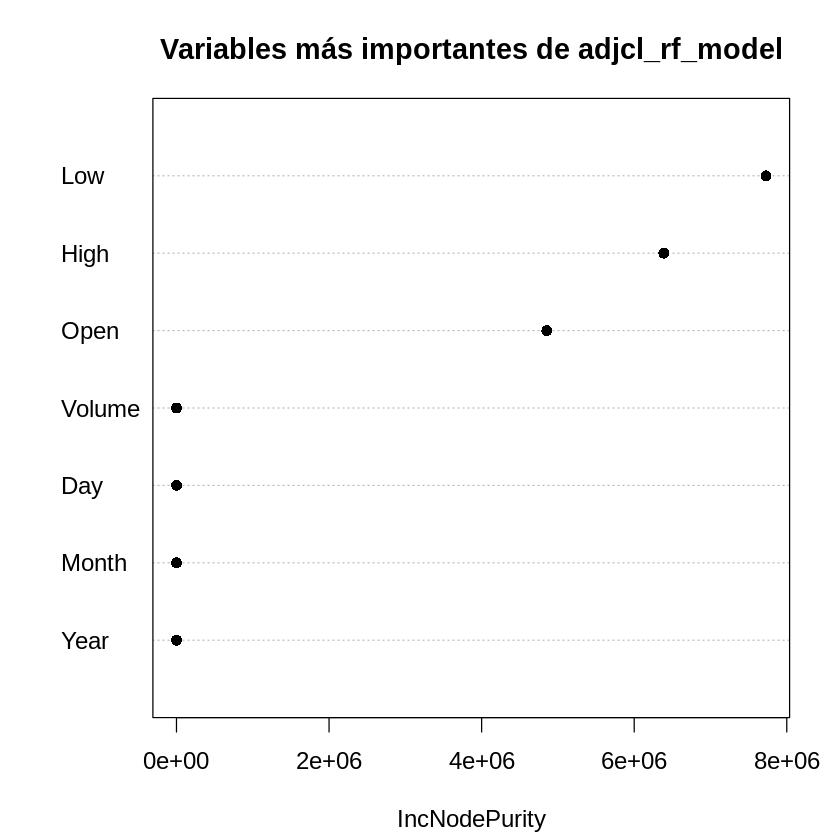

In [41]:
# Visualizamos las variables más importantes de nuestro nuevo modelo

varImpPlot(adjcl_rf_model, main = "Variables más importantes de adjcl_rf_model",
col = "black", pch = 16, cex = 1.2, las = 2)

# Visualización de Pronóstico para los próximos N días
Son N días si quitamos los sábado y domingos

In [42]:
# Convertir stock a formato xts para poder graficar con chartSeries
stock <- as.xts(stock)

op_title <- "OPEN"
hg_title <- "HIGH"
lw_title <- "LOW"
vl_title <- "VOLUME"
adcl_title <- "ADJUSTED CLOSE"


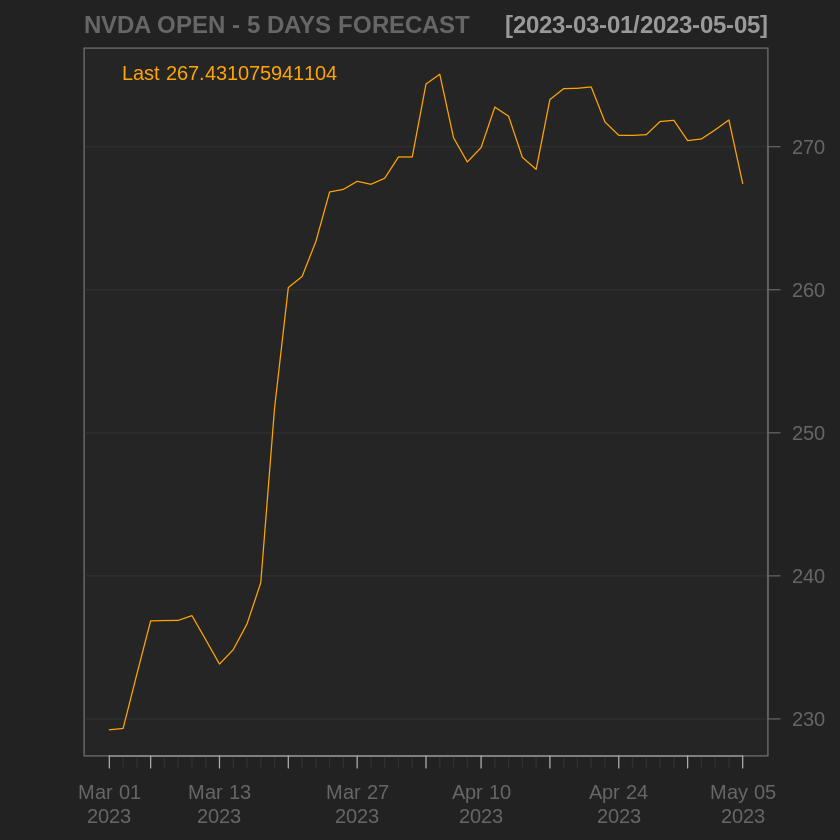

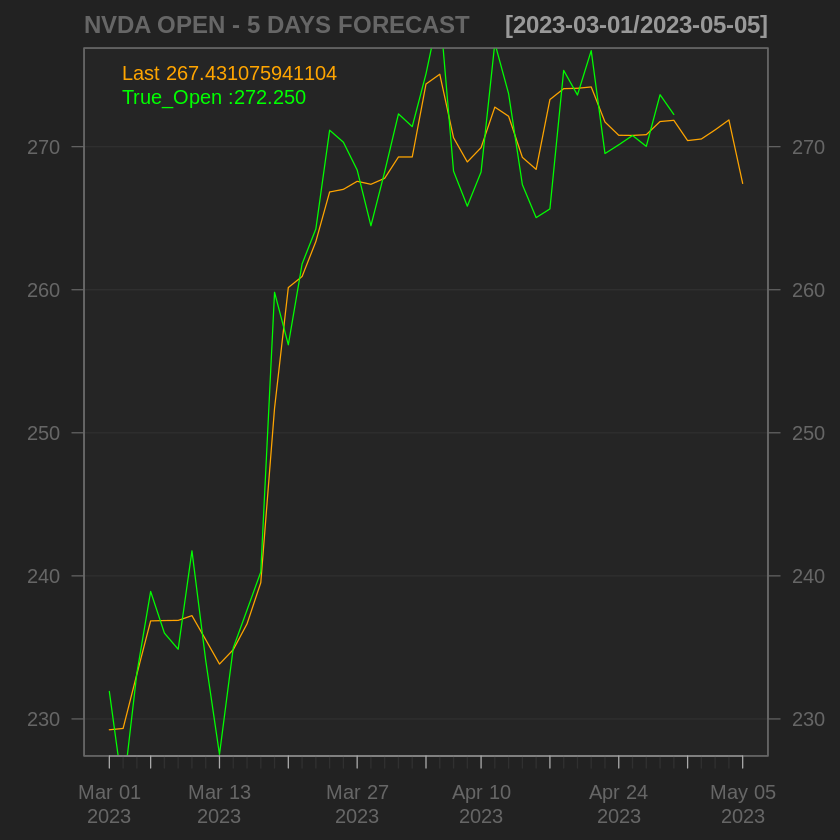

In [50]:
# Open Prediction

Open_prediction <- predict(open_rf_model, stock_open)
Open_prediction <- as.data.frame(Open_prediction)
Open_prediction$Date <- stock_adj_close$Dup_Date
True_Open <- stock[,1]

# Creamos el gráfico

chartSeries(Open_prediction, 
            name = paste0(ticker, " ", op_title, " - ", days_range, " DAYS FORECAST"),
            theme = "black", 
            subset = '2023-03-01::2023-05-20',
            up.col = "orange")

addTA(True_Open, on = 1, col = "green")


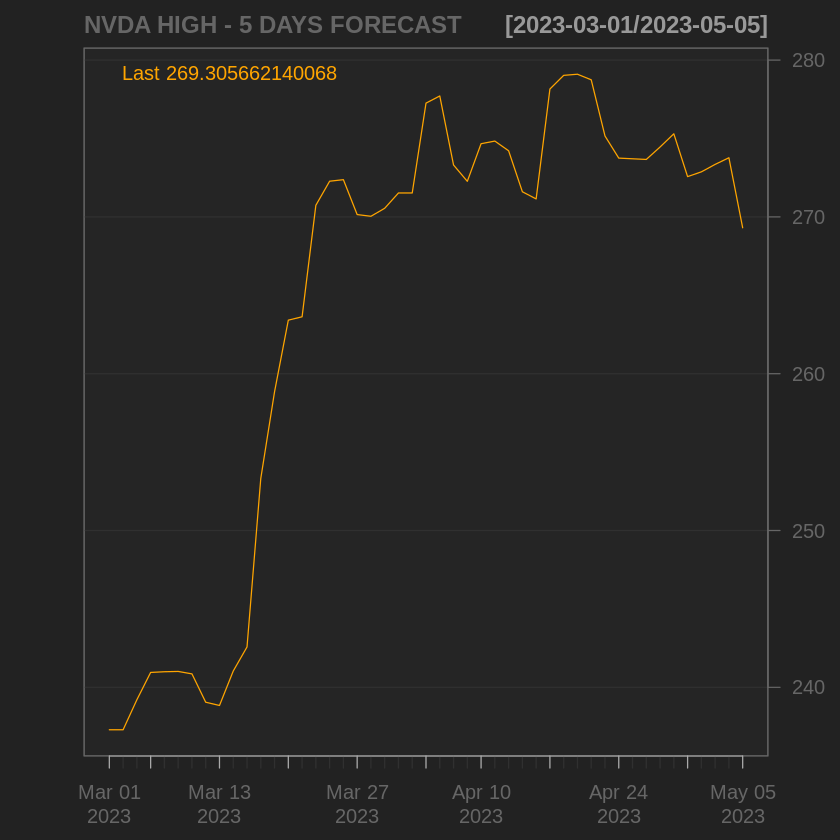

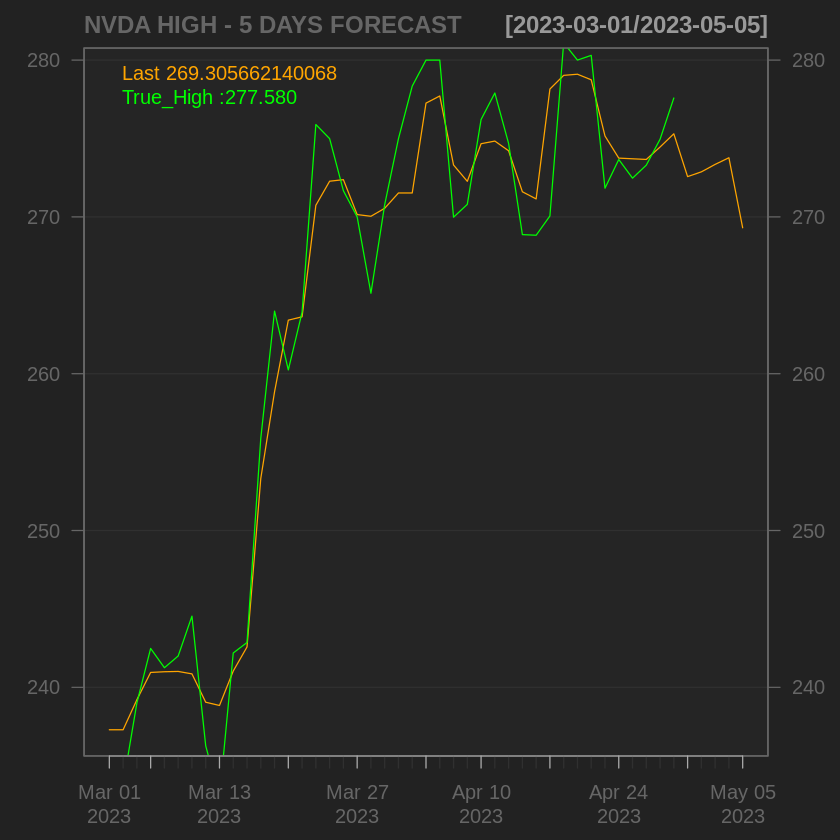

In [51]:
# High Prediction

High_prediction <- predict(high_rf_model, stock_high)
High_prediction <- as.data.frame(High_prediction)
High_prediction$Date <- stock_adj_close$Dup_Date
True_High <- stock[,2]

# Creamos el gráfico

chartSeries(High_prediction, 
            name = paste0(ticker, " ", hg_title, " - ", days_range, " DAYS FORECAST"),
            theme = "black", 
            subset = '2023-03-01::2023-05-20',
            up.col = "orange")

addTA(True_High, on = 1, col = "green")


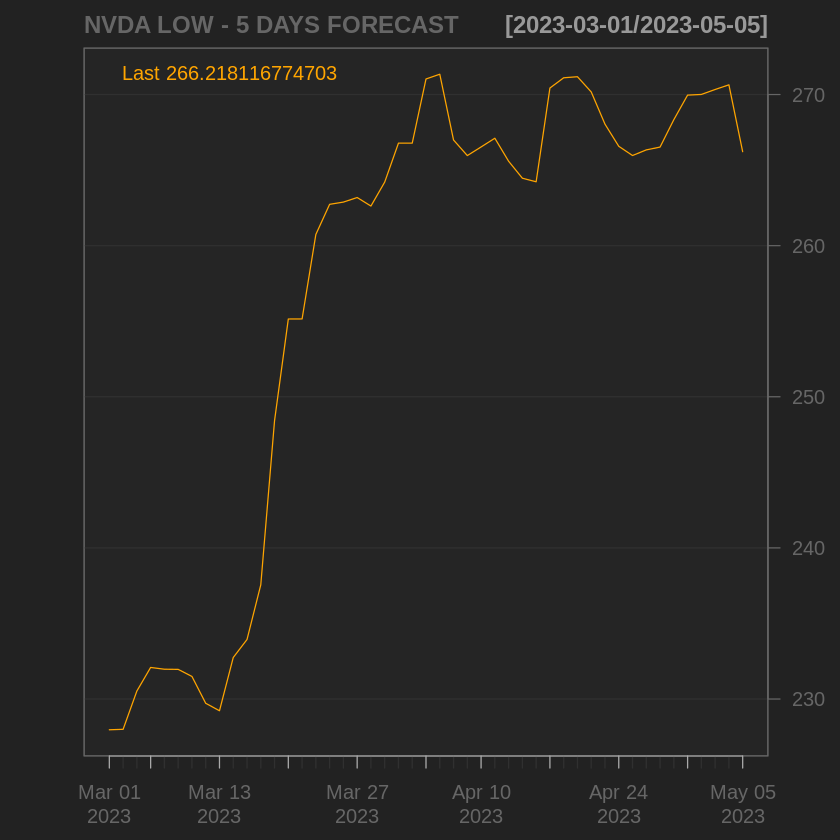

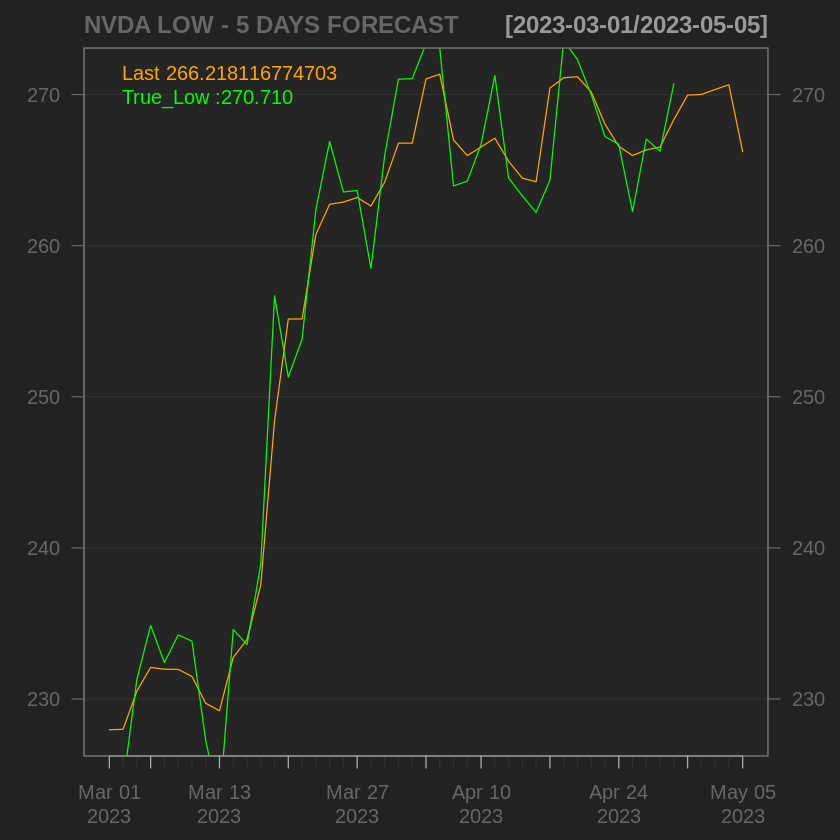

In [52]:
# Low Prediction

Low_prediction <- predict(low_rf_model, stock_low)
Low_prediction <- as.data.frame(Low_prediction)
Low_prediction$Date <- stock_adj_close$Dup_Date
True_Low <- stock[,3]

# Creamos el gráfico

chartSeries(Low_prediction, 
            name = paste0(ticker, " ", lw_title, " - ", days_range, " DAYS FORECAST"),
            theme = "black", 
            subset = '2023-03-01::2023-05-20',
            up.col = "orange")

addTA(True_Low, on = 1, col = "green")


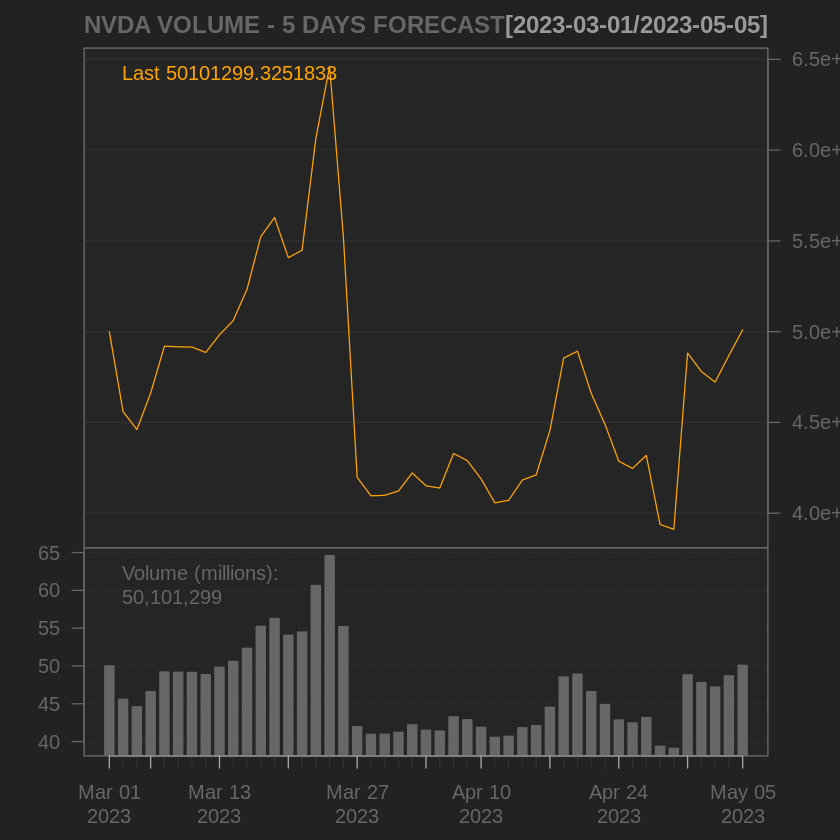

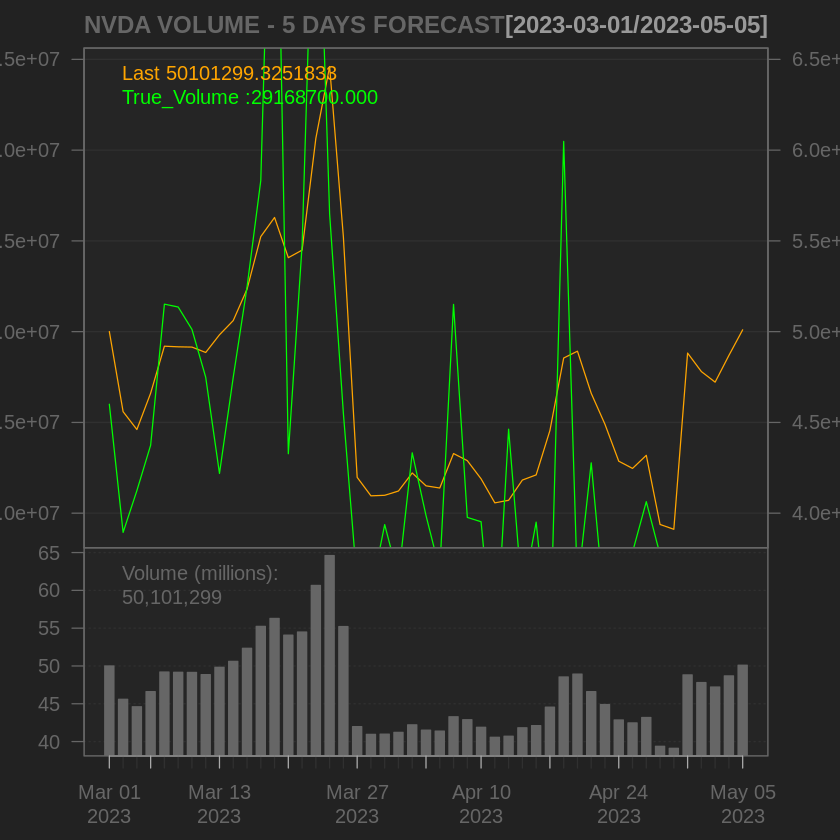

In [53]:
# Volume Prediction

Volume_prediction <- predict(vol_rf_model, stock_volume)
Volume_prediction <- as.data.frame(Volume_prediction)
Volume_prediction$Date <- stock_adj_close$Dup_Date
True_Volume <- stock[,5]

# Creamos el gráfico

chartSeries(Volume_prediction, 
            name = paste0(ticker, " ", vl_title, " - ", days_range, " DAYS FORECAST"),
            theme = "black", 
            subset = '2023-03-01::2023-05-20',
            up.col = "orange")

addTA(True_Volume, on = 1, col = "green")


# Visualización de Adjusted Close Forecast

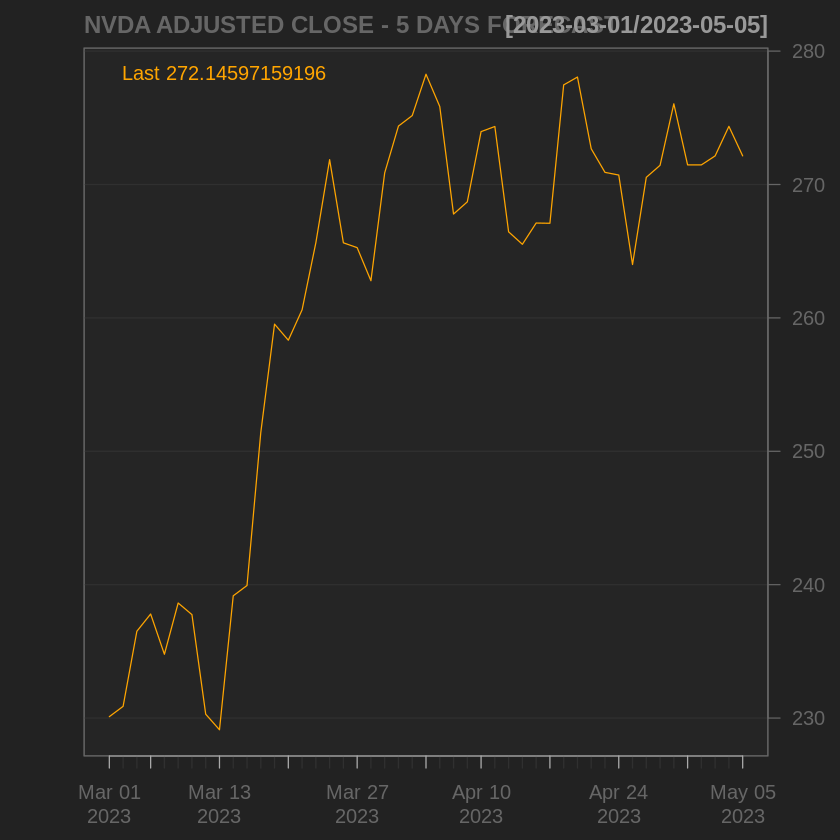

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


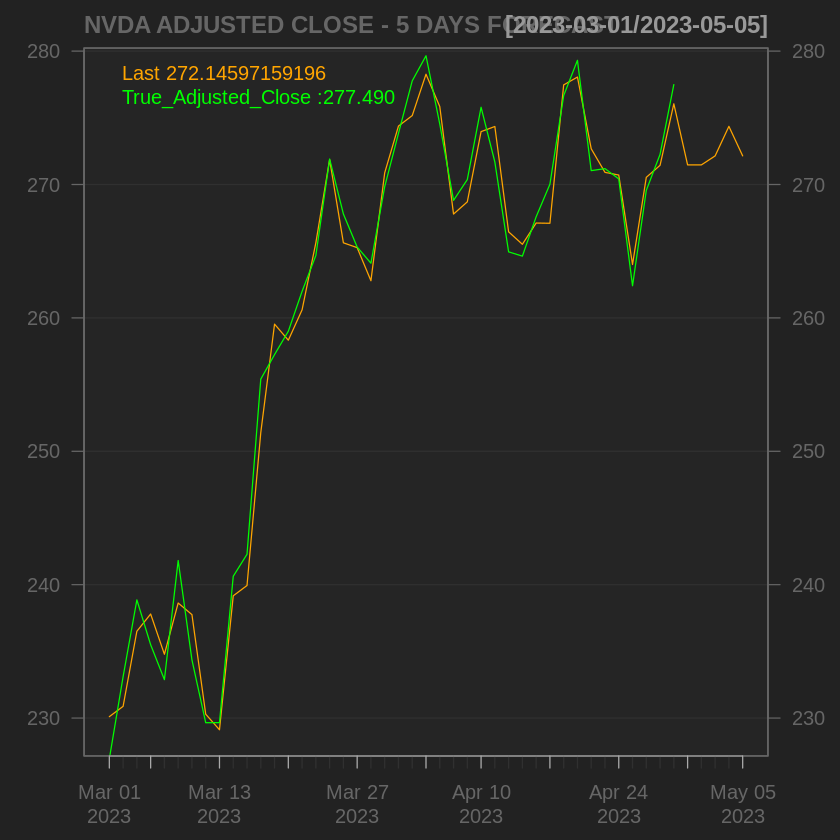

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


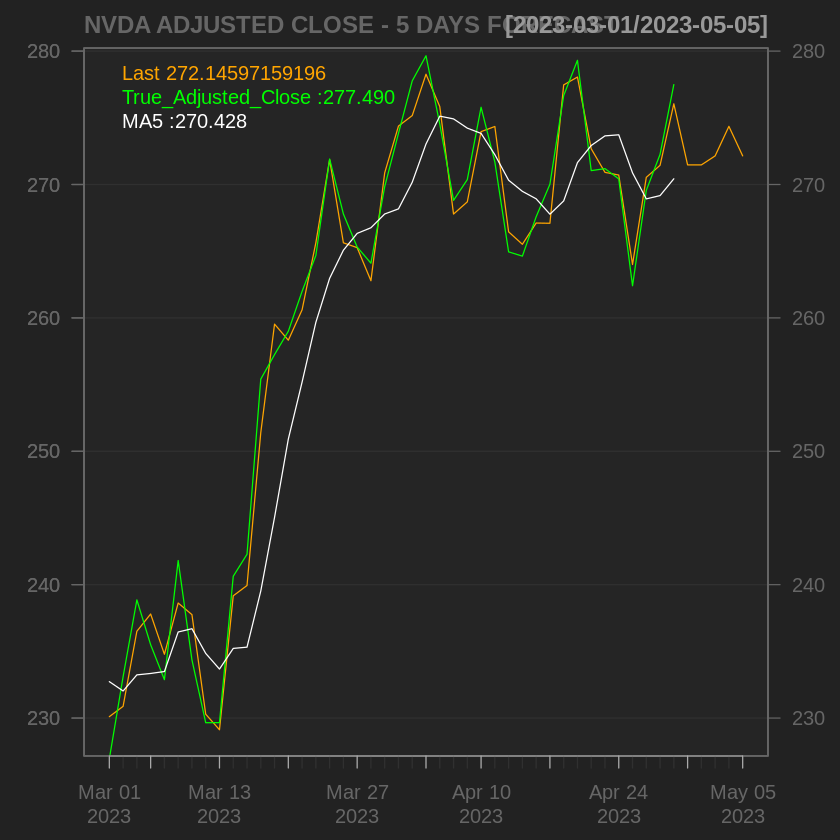

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"subset" is not a graphical parameter”


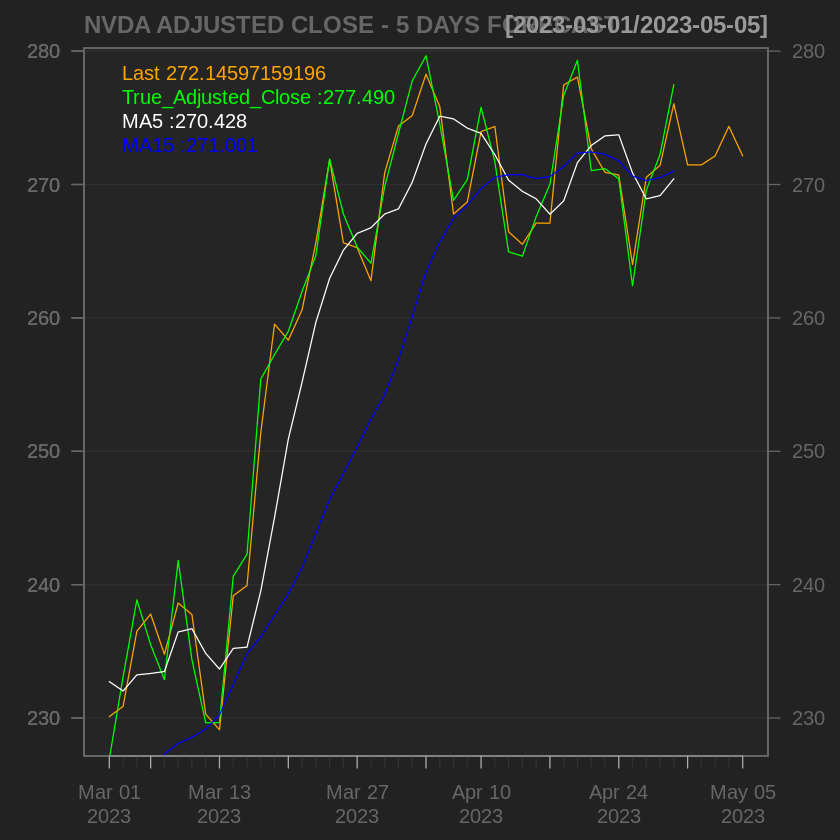

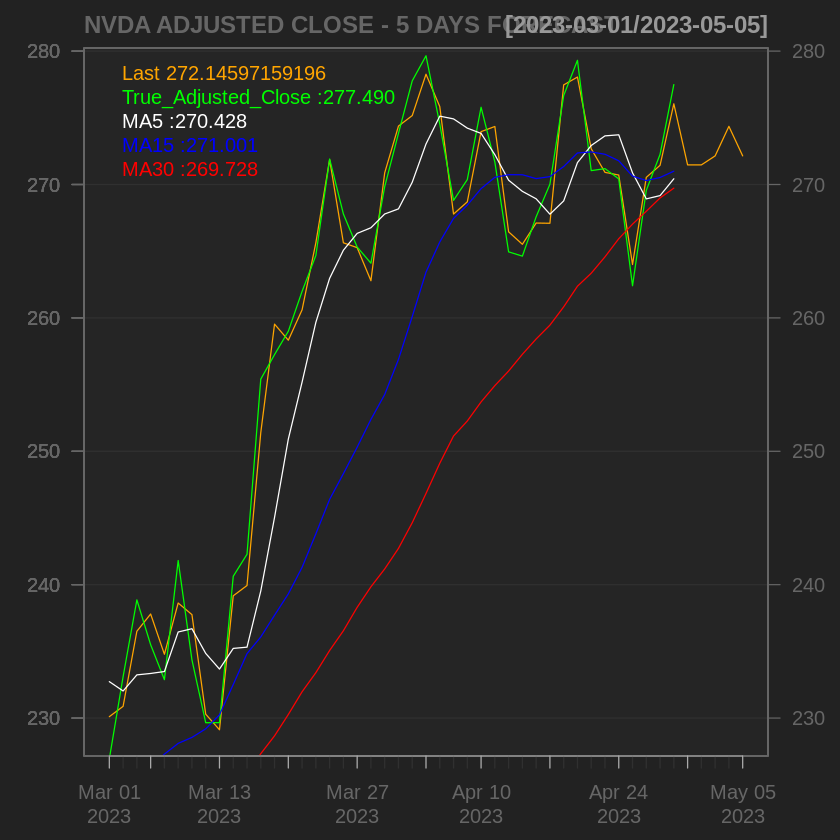

In [54]:
# Adjusted Close Prediction

Adjusted_Close_prediction <- predict(adjcl_rf_model, stock_adj_close)
Adjusted_Close_prediction <- as.data.frame(Adjusted_Close_prediction)
Adjusted_Close_prediction$Date <- stock_adj_close$Dup_Date
True_Adjusted_Close <- stock[,6]

# Creamos el gráfico

chartSeries(Adjusted_Close_prediction, 
            name = paste0(ticker, " ", adcl_title, " - ", days_range, " DAYS FORECAST"),
            theme = "black", 
            subset = '2023-03-01::2023-05-20',
            up.col = "orange")

addTA(True_Adjusted_Close, on = 1, col = "green")

# Añadimos las Medias Móviles

addTA(MA5, on = 1, col = "white", subset = dates)
addTA(MA15, on = 1, col = "blue", subset = dates)
addTA(MA30, on = 1, col = "red", subset = dates)



# Comparamos el pronóstico contra el comprtamiento real 

In [48]:
# Actualizamos nuestros datos a la fecha de hoy

updt_stock <- getSymbols(ticker, src = "yahoo", from = "1900-01-01",
                    to = (today() + 1), periodicity = "daily", auto.assign = FALSE)


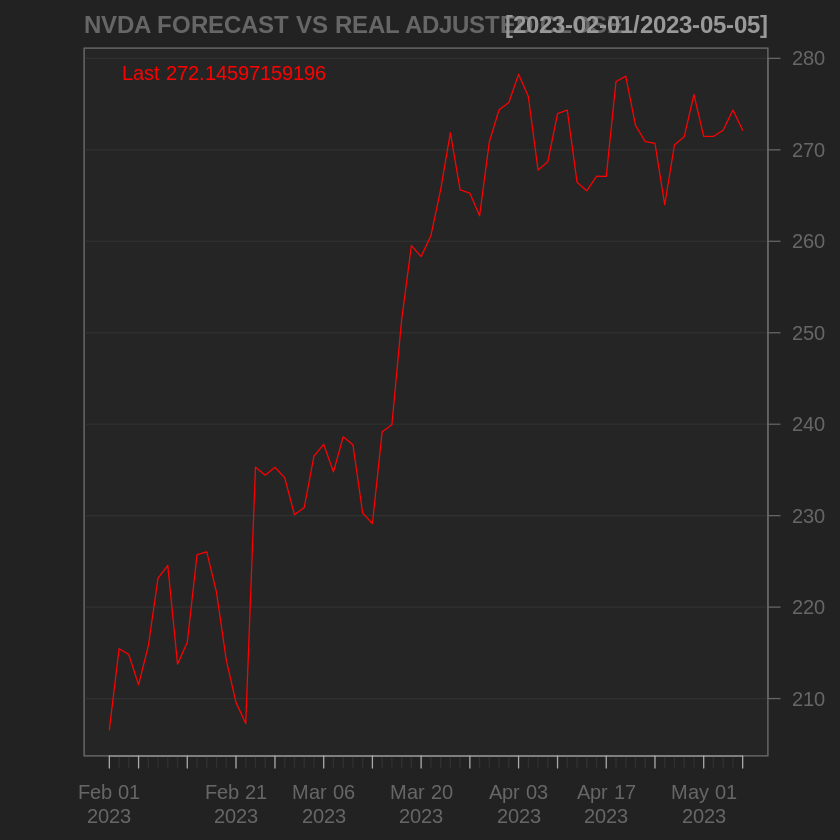

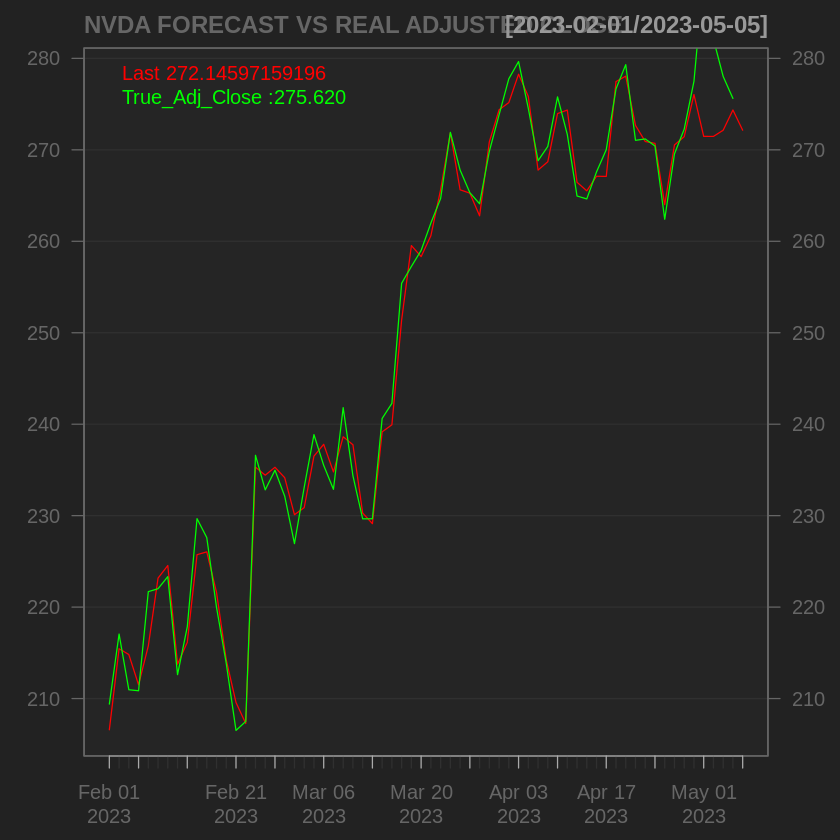

In [56]:
# Visualizamos 

dates <- paste0("2023-02-01::", today() + 1)

True_Adj_Close <- updt_stock[,6]

chartSeries(Adjusted_Close_prediction, 
            name = paste0(ticker, " ", "FORECAST VS REAL ADJUSTED CLOSE"),
            theme = "black",
            subset = dates,
            up.col = "red")

addTA(True_Adj_Close, on = 1, col = "green")


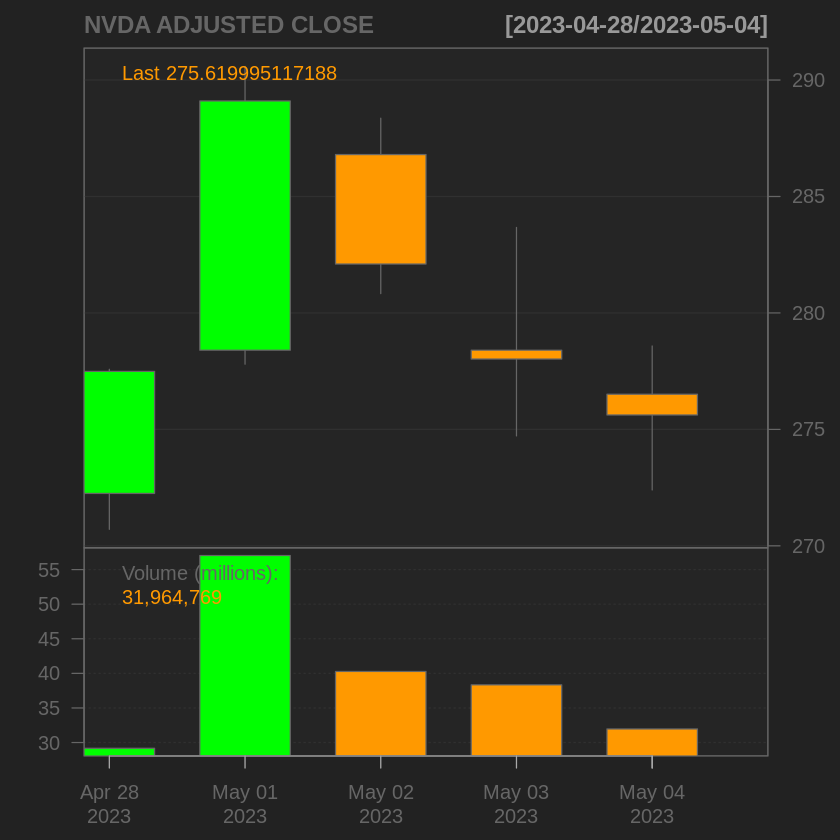

In [64]:
chartSeries(updt_stock, 
            name = paste0(ticker, " ", "ADJUSTED CLOSE"),
            theme = "black",
            subset = "2023-04-28::2023-05-05")